In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
base.classes.keys()

['station', 'measurement']

In [8]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [23]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(measurement.date)).scalar()
recent_date

'2017-08-23'

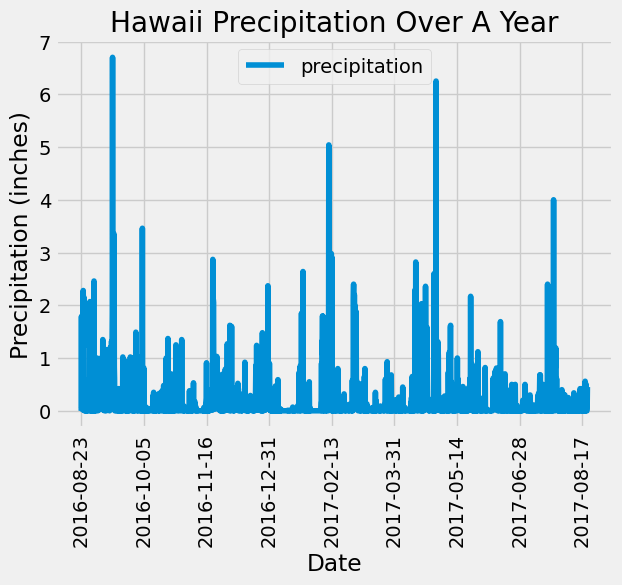

In [24]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = dt.datetime.strptime(recent_date, '%Y-%m-%d')
# Calculate the date one year from the last date in data set.
one_year_ago = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= "2016-08-23").\
    filter(measurement.date <= "2017-08-23").all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip_data, columns=['date', 'precipitation']).set_index('date')

# Sort the dataframe by date
precip_df=precip_df.sort_values(by='date').dropna()
precip_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(rot=90)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Hawaii Precipitation Over A Year")
plt.tight_layout
plt.savefig("Precipitation analysis.png")
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(station.name).distinct().count()
total_stations

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [measurement.station, 
       func.count(measurement.date)]
active_stations = session.query(*sel).\
        group_by(measurement.station).\
        order_by(func.count(measurement.date).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [measurement.station,
       func.min(measurement.tobs),
       func.max(measurement.tobs),
       func.avg(measurement.tobs)]

temp_summary = session.query(*sel).filter(measurement.station == 'USC00519281').group_by(measurement.station)

for station in temp_summary:
    print(station)

('USC00519281', 54.0, 85.0, 71.66378066378067)


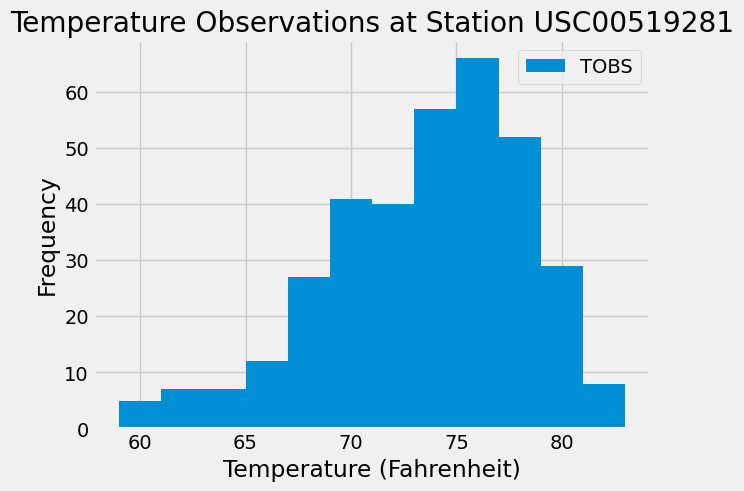

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [measurement.date, 
       measurement.tobs]

station_temps = session.query(*sel).\
        filter(func.strftime(measurement.date) >= one_year_ago, measurement.station == 'USC00519281').\
        group_by(measurement.date).\
        order_by(measurement.date).all()

#Create dataframe to plot histogram
station_temps_df = pd.DataFrame(station_temps, columns=['Measurement Date', 'Temperature'])

plt.hist(station_temps_df['Temperature'],bins=12, label="TOBS")
plt.xlabel("Temperature (Fahrenheit)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Temperature Observations at Station USC00519281")
plt.figsize=(10,7)
plt.savefig('USC00519281_Temps.png',bbox_inches='tight')
plt.show()

# Close Session

In [16]:
# Close Session
session.close()